In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split #library fuer Split
from sklearn import linear_model #lineare Regression
from sklearn import metrics 
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

In [73]:
#Initmessage

#lade von CSV
data_frame_investigated = pd.read_csv("Data/crypto-markets.csv", sep="," )


#print("data collected")

#print(data_frame_investigated.head())

In [74]:
#eliminiere redundante Attribute
REDUNDANT_ATTRIBUTES=['symbol','name'] 
data_frame_investigated.drop(REDUNDANT_ATTRIBUTES,axis=1,inplace=True) #loeschen aus Dataframe
#print(data_frame_investigated.head())

## Führe Label "Trend" ein

In [75]:
# bestimme Trends. (1 für steigender Kurs, 0 für sinkenden Kurs)

df = data_frame_investigated['close'].shift(periods=-1).to_frame() #hier kann der Parmeter üergeben werde, für den der Trend erstellt wird
data_frame_investigated['close_s'] = df

data_frame_investigated = data_frame_investigated[data_frame_investigated['slug'] == 'bitcoin']
data_frame_investigated['trend'] = 5

for i, r in data_frame_investigated.iterrows():
    
    if r["close"] < r["close_s"]:
        #Kurs steigt anschließend
        #data_frame_investigated = data_frame_investigated.set_value(index =i, col = ['trend'], value = 1)
        data_frame_investigated.at[i, 'trend'] = 1
    else:
        #Kurs fällt anschließend
        #data_frame_investigated = data_frame_investigated.set_value(index =i, col = ['trend'], value = 0)  
        data_frame_investigated.at[i, 'trend'] = 0
        
#Y Wert für Klassifizierer -> Trendwerte als eigene Spalte
data_frame_trend = data_frame_investigated['trend'].to_frame() 

In [76]:
np.size(data_frame_trend)

1902

## Adaboost Classifier

Score train: 0.5862068965517241
Score test: 0.5392670157068062
Bias: 0.8070452155625657
Confusion Matrix in Form: tn, fp, fn, tp 
 [[218 647]
 [149 888]]


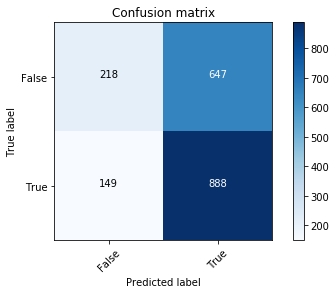

In [77]:
def cryptoclassifier(crypto_id, feature_to_compare,crypto_id_feature_name="slug", documentMode=True):
    
    #Cryptos Gruppieren
    
    #ich kann nur anhand von Tagen schliessen, an denen die Crypto Existiert
    #erstmal alle Tage holen an denen die Crypto gehandelt wird
    dates_of_crypto_trade= data_frame_investigated[
        data_frame_investigated[crypto_id_feature_name] == crypto_id
    ]['date']
    
   
    #print(dates_of_crypto_trade.head())
    
    #dann die Tupel Filtern, nur die Tage an denen Crypto getraded wird uebernehmen,
    #nur compare feature uebernehmen
    data_frame_id_exists= data_frame_investigated[
        data_frame_investigated['date'].isin(dates_of_crypto_trade)
    ][['date',crypto_id_feature_name,feature_to_compare]]
    
    #daten Pivotieren, so dass Cryptos zu columns werden
    data_frame_id_exists= data_frame_id_exists.pivot(
        index='date', columns=crypto_id_feature_name, values=feature_to_compare
        ).reset_index()
    
 
    
    data_frame_id_exists=data_frame_id_exists.fillna(value=0)
    data_frame_id_exists=data_frame_id_exists.dropna()
    
   
    #date rausloeschen
    data_frame_id_exists.drop('date',axis=1,inplace=True)
    #print("cleaned Frame")
    #print(data_frame_id_exists.head())
    data_frame_for_predictions = data_frame_id_exists #copy data_frame_id_exists just for safety purposes
    
    #print("Größe data_frame_for_predictions:", np.size(data_frame_for_predictions))
    
    ###############Train Test Split:
    Y = data_frame_trend.values.ravel() #changes Y from collumn to 1d array
    
    #check size of Y
    #print(np.size(Y)) 
    
    
    feature_train, feature_test, y_train, y_test = train_test_split (
        data_frame_id_exists,
        Y,
        test_size=0.1
    )

    ##############Classifier machen
    classifier_model = AdaBoostClassifier(
        base_estimator=None, learning_rate=0.5, n_estimators=100, random_state=123)



        #Classifier fitten
    classifier_model.fit(feature_train, y_train) #trains Classifier with test_split
    Score_train = classifier_model.score(feature_train,y_train) #score test score value
    Score_test = classifier_model.score(feature_test,y_test) #model score value
    predictions = classifier_model.predict(data_frame_for_predictions) #predicts y data on basis of classifier
    confusionMatrix = confusion_matrix(Y, predictions)
    Bias = ((confusionMatrix[1][1]+confusionMatrix[0][1])/(confusionMatrix[0][0]+confusionMatrix[0][1]+confusionMatrix[1][0]+confusionMatrix[1][1]))
    
    if documentMode: print("Score train:", Score_train)
    if documentMode: print("Score test:", Score_test)
    if documentMode: print("Bias:", Bias)
    #if documentMode: print("Classifier Predictions:", predictions)
    if documentMode: print('Confusion Matrix in Form: tn, fp, fn, tp \n', confusionMatrix)

    #dont delete values
    return [classifier_model,
            Score_train,
            Score_test,
            feature_train,
            y_train,
            feature_test,
            y_test,
            list(data_frame_id_exists),
            list(predictions),
            Y,
            predictions,
            confusionMatrix
           ]


#Hier können Parameter übergeben werden: 
#auf Basis welches Parameters der anderen Coins ('close', 'spread', 'volume', etc.) soll klassifiziert werden?
classifier_result=cryptoclassifier('bitcoin','close')




def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(classifier_result[9], classifier_result[10])
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, 
                      classes=['False', 'True'],
                      title='Confusion matrix')

#plt.savefig('confusion.png', dpi=300)

## ROC Kurve


In [78]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(classifier_result[9], classifier_result[10])
roc_auc = auc(fpr,tpr)

print(tpr)
print(fpr)
print(thresholds)

[0.   0.86 1.  ]
[0.   0.75 1.  ]
[2 1 0]


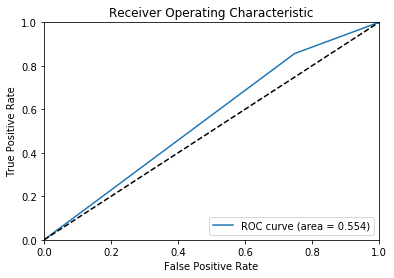

In [79]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.savefig("figures/ROC_AdaBoost_bitcoin", bbox_inches="tight", dpi=200)
plt.show()

## Classifier Score mit sich verändernder learning rate [0.05 , 1

In [80]:
#For each learning rate new clasifier run
list_adascores = []

for l_rate in np.arange(0.05,1,0.05):
    
    classifier_model = AdaBoostClassifier(
        base_estimator=None, learning_rate=l_rate, n_estimators=100, random_state=123)
    
    classifier_model.fit(classifier_result[3], classifier_result[4]) #trains Classifier with test_split
    Score_test = classifier_model.score(classifier_result[5], classifier_result[6]) #model score value
    
    list_adascores.append(Score_test)
    
print(list_adascores)

[0.5706806282722513, 0.5392670157068062, 0.5392670157068062, 0.5287958115183246, 0.5287958115183246, 0.5287958115183246, 0.5392670157068062, 0.5392670157068062, 0.5392670157068062, 0.5392670157068062, 0.5392670157068062, 0.5392670157068062, 0.5392670157068062, 0.5392670157068062, 0.5445026178010471, 0.5445026178010471, 0.5445026178010471, 0.5445026178010471, 0.5445026178010471]
